In [14]:
# Import necessary libraries
import os
import sys
# Add the utils folder to the system path so we can import custom modules
sys.path.append(os.path.abspath("utils"))
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from utils.reproducibility_utils import seed_everything
from utils.data_loading import load_data, load_test_data, feature_names

# Set the plotting style for better-looking visualizations
plt.style.available
plt.style.use('seaborn-v0_8')

In [15]:
# Set random seed for reproducibility across runs
# This ensures that your results will be the same every time you run the notebook
seed_everything(42)  # for reproducibility

# Load the Data

# Getting Started with the Competition

This notebook will guide you through the complete workflow for participating in the sideslip angle prediction challenge:

## Workflow Overview:
1. **Load and preprocess data** - Learn about proper train/validation/test splitting
2. **Explore the data** - Understand the input features and target variable  
3. **Build a neural network** - Implement a simple RNN architecture
4. **Train the model** - Use best practices like early stopping and model checkpointing
5. **Evaluate performance** - Validate your model and visualize predictions
6. **Make predictions** - Generate test set predictions for submission

Let's begin! 🚀

In [16]:
print("Loading train data...")
train_dataloader, val_dataloader, pipeline = load_data(
    train_path = r"C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train",  # Path to training data
    train_ratio = 0.8,  # Use 80% for training, 20% for validation
    batchsize = 512,  # Number of samples per batch
    # columns_to_standardize = feature_names,  # Option to specify which columns to standardize
    columns_to_drop = ["sideSlip", "vyCG", "time", "longitude","latitude"],  # Remove these from features
    sequence_length = 20,  # Number of time steps in each sequence (t-19 to t0)
    threshold = True,  # Enable velocity thresholding
    threshold_value = 3.0,  # Only keep samples where vehicle speed > 3 m/s
    threshold_column = "vxCG",  # Column to apply threshold on (longitudinal velocity)
    target = "sideSlip",  # The variable we want to predict
    scaling = True,  # Apply standardization to features
    seed = 42,  # Random seed for train/val split
)

Loading train data...
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_001.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_002.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_003.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_004.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_005.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_006.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_007.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_008.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_009.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\train\train_part_010.csv
C:\Users\vibho\Documents\VSA\sensing-the-drift\datasets_challenge\tr

## Applying label densities to each label

## test 2 - working

In [17]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Applying label density based on binning + Gaussian smoothing
def apply_label_density(datasets, num_bins, sigma=2):
    """
    Compute smoothed label densities for regression targets using binning + Gaussian smoothing.

    Args:
        datasets: list of datasets, each with attribute .y
        num_bins: number of bins for discretizing target space
        sigma: standard deviation for Gaussian smoothing

    Returns:
        densities: tensor of smoothed densities for all targets
    """
    # 1. Collect all targets into one tensor
    all_targets = torch.cat([
        d.y if isinstance(d.y, torch.Tensor) else torch.as_tensor(d.y)
        for d in datasets
    ], dim=0)
    print(f"Total number of targets: {len(all_targets)}")

    # 2. Create bins over the target range
    y_min, y_max = all_targets.min().item(), all_targets.max().item()
    bins = torch.linspace(y_min, y_max, num_bins)

    # 3. Compute histogram (count targets in each bin)
    hist = torch.histc(all_targets.float(), bins=num_bins, min=y_min, max=y_max)

    # 4. Smooth histogram with Gaussian filter
    smoothed = gaussian_filter1d(hist.numpy(), sigma=sigma)

    # 5. Interpolate densities back to original targets
    densities = np.interp(all_targets.numpy(), bins.numpy(), smoothed)

    # 6. Normalize densities to [0, 1]
    densities = (densities - densities.min()) / (densities.max() - densities.min())
    densities = torch.tensor(densities, dtype=torch.float32)
    print(f"Densities shape: {densities.shape}")

    # 7. Assign densities back to individual datasets
    start = 0
    for d in datasets:
        n = len(d.y)
        d.densities = densities[start:start + n]
        start += n
        print(f"Assigned densities to dataset with {n} samples.")

    return densities

# Example usage
densities = apply_label_density(train_dataloader.dataset.dataset.datasets, num_bins=1000, sigma=2)


Total number of targets: 137920
Densities shape: torch.Size([137920])
Assigned densities to dataset with 11841 samples.
Assigned densities to dataset with 88 samples.
Assigned densities to dataset with 767 samples.
Assigned densities to dataset with 329 samples.
Assigned densities to dataset with 8684 samples.
Assigned densities to dataset with 799 samples.
Assigned densities to dataset with 482 samples.
Assigned densities to dataset with 149 samples.
Assigned densities to dataset with 1201 samples.
Assigned densities to dataset with 324 samples.
Assigned densities to dataset with 19721 samples.
Assigned densities to dataset with 377 samples.
Assigned densities to dataset with 174 samples.
Assigned densities to dataset with 234 samples.
Assigned densities to dataset with 96 samples.
Assigned densities to dataset with 984 samples.
Assigned densities to dataset with 407 samples.
Assigned densities to dataset with 47 samples.
Assigned densities to dataset with 22220 samples.
Assigned dens

In [18]:
print((train_dataloader.dataset.dataset.datasets[0].densities[:10]))

tensor([0.0492, 0.0528, 0.0401, 0.0159, 0.0153, 0.0270, 0.0163, 0.0179, 0.0183,
        0.0146])


# Visualize an Example of a single sample

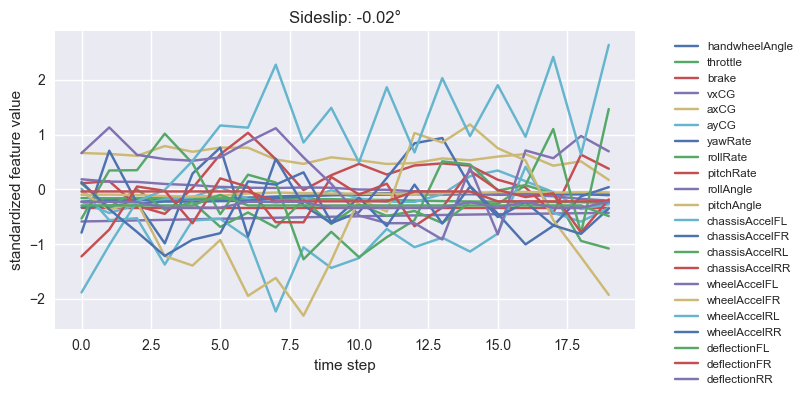

In [19]:
# Get one batch of data from the training dataloader
X, y, d = next(iter(train_dataloader))

# Visualize the first sample in the batch
plt.figure(figsize=(8,4))
plt.plot(X[0,:,:], label=feature_names)  # Plot all 22 features over 20 time steps
plt.title("Sideslip: "+str(round(y[0].item(),2))+"°")  # Show the target value
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.xlabel("time step")
plt.ylabel("standardized feature value")
plt.show()

# Testing with GRU + CNN - test
Only GRU performs better than +CNN

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size=1, rnn_units=32, fc_units=32):
        super().__init__()
        # self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1) #CNN layer makes the performance little bad
        self.gru = nn.GRU(input_size, rnn_units, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(rnn_units*2, 1)
        self.layernorm = nn.LayerNorm(rnn_units*2)
        self.fc = nn.Sequential(
            nn.Linear(rnn_units*2, fc_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fc_units, output_size)
        )

    def forward_features(self, x):
        # 1️⃣ Get GRU outputs
        x, _ = self.gru(x)  # [B, T, H*2]
        
        # 2️⃣ Compute attention weights and weighted sum
        attn_weights = torch.softmax(self.attn(x), dim=1)
        
        context = torch.sum(attn_weights * x, dim=1)  # [B, H*2]
        # 3️⃣ Normalize context (these are the "features" for FDS)
        context = self.layernorm(context)
        
        return context

    def forward(self, x):
        # 1️⃣ Extract features once
        context = self.forward_features(x)
        # 2️⃣ Final prediction
        return self.fc(context)

print("✅ Model definition complete.")

✅ Model definition complete.


In [21]:
#test
# Set device for computation (CPU or GPU)
device = "cuda"  # Change to "cuda" if you have a GPU available

# Model hyperparameters
input_size = X.shape[2]  # Number of features (22 in this case)
rnn_units = 128  # Number of units in RNN hidden state
fc_units = 128  # Number of units in fully connected layer
output_size = 1  # Single output (sideslip angle)
lr = 0.0003  # Learning rate for optimizer

model = GRU(
    input_size=input_size,
    fc_units=fc_units,
    rnn_units=rnn_units,
).to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) - measures average prediction error
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for weight updates

## FDS Utilities 

In [22]:
import torch, numpy as np
from scipy.ndimage import gaussian_filter1d

def compute_bin_edges(y, num_bins):
    y = y.squeeze().cpu().numpy()
    y_min, y_max = y.min(), y.max()
    # +1 for edges; centers will be midpoints if needed
    edges = np.linspace(y_min, y_max, num_bins + 1)
    return edges

def assign_bins(y, edges):
    # y: [N,1] tensor -> bin indices [N]
    y_np = y.squeeze().cpu().numpy()
    idx = np.clip(np.searchsorted(edges, y_np, side="right") - 1, 0, len(edges)-2)
    return torch.from_numpy(idx).long()

def per_bin_means(features, bin_idx, num_bins):
    """
    features: [N, D] (torch)
    bin_idx:  [N]    (torch)
    returns means: [num_bins, D], counts: [num_bins]
    """
    N, D = features.size()
    means = torch.zeros(num_bins, D)
    counts = torch.zeros(num_bins, dtype=torch.long)
    for b in range(num_bins):
        mask = (bin_idx == b)
        if mask.any():
            means[b] = features[mask].mean(dim=0)
            counts[b] = mask.sum()
    return means, counts

def fill_empty_bins_linear(means_np, counts_np):
    """
    means_np: [B, D], counts_np: [B]
    Fills empty bins by linear interp along bin axis, per feature dim.
    """
    B, D = means_np.shape
    x = np.arange(B)
    nonempty = counts_np > 0
    if nonempty.sum() == 0:
        return means_np  # degenerate case
    for d in range(D):
        y = means_np[:, d]
        y[~nonempty] = np.interp(x[~nonempty], x[nonempty], y[nonempty])
    return means_np

def smooth_means_gaussian(means_np, sigma):
    """
    Apply 1D Gaussian smoothing along bin axis for each feature dim.
    means_np: [B, D]
    """
    B, D = means_np.shape
    out = np.zeros_like(means_np)
    for d in range(D):
        out[:, d] = gaussian_filter1d(means_np[:, d], sigma=sigma, mode="nearest")
    return out


## Training based on label density - test 0

In [23]:
def weighted_focal_mse_loss(y_pred, y_true, label_density, alpha=0.6, beta=2.0, gamma=1.0, eps=1e-6):
    weights = (1.0 / (label_density + eps)) ** alpha
    error = torch.abs(y_pred - y_true)
    focal_weight = (1 - torch.exp(-beta * error)) ** gamma
    loss = (weights * focal_weight * error**2).mean()
    return loss

## FDS Initialization

In [24]:
#FDS#
NUM_BINS   = 1000      # same idea as your LDS (500–1000 good)
SIGMA      = 2         # Gaussian smoothing (in bins)
LAMBDA_CAL = 0.2       # weight for calibration loss (try 0.05→0.5)
WARMUP_EPOCHS = 3      # train normally first, then enable FDS

def collect_and_smooth(model, train_loader, device, num_bins, sigma):
    model.eval()
    feats_list, y_list = [], []
    with torch.no_grad():
        for x, y, _ in train_loader:
            x = x.to(device); y = y.to(device)
            feats = model.forward_features(x)        # [B, H]
            feats_list.append(feats.cpu())
            y_list.append(y.cpu())

    all_feats = torch.cat(feats_list, dim=0)         # [N, H]
    all_y     = torch.cat(y_list, dim=0)             # [N, 1]

    # --- binning & per-bin means ---
    edges = compute_bin_edges(all_y, NUM_BINS)       # from the utils we wrote
    bin_idx = assign_bins(all_y, edges)
    means, counts = per_bin_means(all_feats, bin_idx, NUM_BINS)

    # --- fill empty bins, then smooth along bin axis ---
    means_np  = means.numpy()
    counts_np = counts.numpy()
    means_np  = fill_empty_bins_linear(means_np, counts_np)
    means_np  = smooth_means_gaussian(means_np, SIGMA)

    smoothed_means = torch.from_numpy(means_np).float().to(device)  # [BINS, H]
    edges_t        = torch.from_numpy(edges).float().to(device)     # [BINS+1]
    return smoothed_means, edges_t

mse = torch.nn.MSELoss(reduction="mean")

def calibration_loss(features, y, smoothed_means, edges):
    # map each y to its bin, gather target mean
    y_np   = y.detach().squeeze().cpu().numpy()
    e_np   = edges.detach().cpu().numpy()
    idx_np = np.clip(np.searchsorted(e_np, y_np, side="right") - 1, 0, len(e_np)-2)
    idx    = torch.from_numpy(idx_np).long().to(features.device)
    mu     = smoothed_means[idx]  # [B, H]
    return mse(features, mu)
print("✅ FDS utility functions defined.")

✅ FDS utility functions defined.


In [25]:
# Training configuration
num_epochs = 50
early_stop_thresh = 10
best_loss = np.inf
best_epoch = -1
best_model_state = None

train_curve, val_curve = [], []

# FDS state (stats for the *next* epoch); make sure WARMUP_EPOCHS/NUM_BINS/SIGMA/LAMBDA_CAL are defined above
fds_means, fds_edges = None, None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    use_fds = (epoch >= WARMUP_EPOCHS) and (fds_means is not None)

    # ---------- TRAIN ----------
    for step, (x, y, densities) in enumerate(train_dataloader):
        X = x.to(device)
        y = y.to(device).reshape([len(y), 1])
        dens = densities.to(device)

        optimizer.zero_grad()

        # forward
        preds = model(X)
        main_loss = weighted_focal_mse_loss(preds, y, dens)

        if use_fds:
            feats = model.forward_features(X)           # [B, H]
            cal_loss = calibration_loss(feats, y, fds_means, fds_edges)
            loss = main_loss + LAMBDA_CAL * cal_loss
        else:
            loss = main_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / (step + 1)
    train_curve.append(avg_train_loss)

    # ---------- VALIDATE ----------
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_step, (x, y, d) in enumerate(val_dataloader):
            Xv = x.to(device)
            yv = y.to(device).reshape([len(y), 1])
            dv = d.to(device)

            y_pred = model(Xv)
            val_loss = weighted_focal_mse_loss(y_pred, yv, dv)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / (val_step + 1)
    val_curve.append(avg_val_loss)

    # ---------- FDS stats for NEXT epoch ----------
    if epoch >= WARMUP_EPOCHS - 1:
        fds_means, fds_edges = collect_and_smooth(
            model, train_dataloader, device,
            num_bins=NUM_BINS, sigma=SIGMA
        )

    # ---------- LOG / CHECKPOINT / EARLY STOP ----------
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}", end="")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": best_loss
        }, "best_model.pth")
        print(f"  → New best validation loss: {best_loss:.5f}")
    elif epoch - best_epoch > early_stop_thresh:
        print(f"  → Early stopping triggered at epoch {epoch+1} (best epoch: {best_epoch+1})")
        break
    else:
        print("")

# ---------- LOAD BEST MODEL ----------
if best_epoch != -1:
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"\n✓ Best model from epoch {best_epoch+1} loaded (Val Loss: {best_loss:.5f})")
else:
    print("\n⚠ No improvement found, using current model")

Epoch 1/50 | Train Loss: 1.64809 | Val Loss: 0.64831  → New best validation loss: 0.64831
Epoch 2/50 | Train Loss: 0.44614 | Val Loss: 0.25575  → New best validation loss: 0.25575
Epoch 3/50 | Train Loss: 0.27055 | Val Loss: 0.19118  → New best validation loss: 0.19118
Epoch 4/50 | Train Loss: 0.32619 | Val Loss: 0.18044  → New best validation loss: 0.18044
Epoch 5/50 | Train Loss: 0.27851 | Val Loss: 0.16504  → New best validation loss: 0.16504
Epoch 6/50 | Train Loss: 0.24688 | Val Loss: 0.15971  → New best validation loss: 0.15971
Epoch 7/50 | Train Loss: 0.23580 | Val Loss: 0.16221
Epoch 8/50 | Train Loss: 0.22095 | Val Loss: 0.15779  → New best validation loss: 0.15779
Epoch 9/50 | Train Loss: 0.21469 | Val Loss: 0.16060
Epoch 10/50 | Train Loss: 0.20885 | Val Loss: 0.15763  → New best validation loss: 0.15763
Epoch 11/50 | Train Loss: 0.20227 | Val Loss: 0.16898
Epoch 12/50 | Train Loss: 0.19405 | Val Loss: 0.13926  → New best validation loss: 0.13926
Epoch 13/50 | Train Loss: 0.

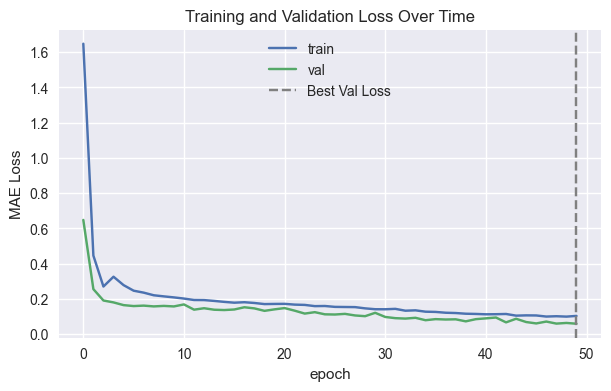

In [26]:
# Visualize training progress
plt.figure(figsize=(7, 4))
plt.plot(train_curve, label="train")
plt.plot(val_curve, label="val")
plt.axvline(x=best_epoch, color='gray', linestyle='--', label='Best Val Loss')
plt.xlabel("epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.title("Training and Validation Loss Over Time")
plt.show()

# Evaluate the Training

## Understanding the Training Curves

Looking at the plot above, you should observe:

**Good signs:**
- Training loss decreases steadily
- Validation loss decreases and stabilizes
- The gap between train and validation is small (indicates good generalization)

**Warning signs to watch for:**
- Large gap between train and val = **overfitting** (model memorizes training data)
- Both losses stay high = **underfitting** (model is too simple)
- Validation loss increases while training decreases = **overfitting**

The vertical dashed line shows where we achieved the best validation performance.

## Verification Step

Let's verify that we correctly loaded the best model by evaluating it one more time on the validation set. The loss should match the best validation loss from training.

## test 0 with density based loss

In [27]:
# Evaluate model on validation set
model.eval()
running_val_loss = 0.0

with torch.no_grad():
    for val_step, (x, y, d) in enumerate(val_dataloader):
        X_val = x.to(device)
        y_val = y.to(device).reshape(-1, 1)
        d_val = d.to(device)  # label density for weighting

        y_pred = model(X_val)
        val_loss = weighted_focal_mse_loss(y_pred, y_val, d_val)

        running_val_loss += val_loss.item()

avg_val_loss = running_val_loss / (val_step + 1)
print(f"Final Evaluation on Validation Set - Weighted Focal MSE Loss: {avg_val_loss:.5f}")

Final Evaluation on Validation Set - Weighted Focal MSE Loss: 0.05895


## Visual Sanity Check

Now let's load the complete training dataset (without shuffling) to visualize how well our model captures the sideslip signal pattern.

**Important Note:** We're loading ALL training data here (including what was used for validation), so the model will perform slightly better than the validation loss suggests. This is called **data leakage** and should normally be avoided in proper evaluation. However, for visualization purposes, this helps us see that the model learned meaningful patterns.

In [32]:
# Load complete training data (unshuffled) for visualization
# This uses the same preprocessing pipeline to ensure consistency
train_dataloader_unshuffled = load_test_data(
    test_path="sensing-the-drift/datasets_challenge/train",
    batchsize=512,
    pipeline=pipeline,  # Use the same preprocessing as training
    load_anonymized_data=False  # We have ground truth for training data
)

sensing-the-drift/datasets_challenge/train\train_part_001.csv
sensing-the-drift/datasets_challenge/train\train_part_002.csv
sensing-the-drift/datasets_challenge/train\train_part_003.csv
sensing-the-drift/datasets_challenge/train\train_part_004.csv
sensing-the-drift/datasets_challenge/train\train_part_005.csv
sensing-the-drift/datasets_challenge/train\train_part_006.csv
sensing-the-drift/datasets_challenge/train\train_part_007.csv
sensing-the-drift/datasets_challenge/train\train_part_008.csv
sensing-the-drift/datasets_challenge/train\train_part_009.csv
sensing-the-drift/datasets_challenge/train\train_part_010.csv
sensing-the-drift/datasets_challenge/train\train_part_011.csv
sensing-the-drift/datasets_challenge/train\train_part_012.csv
sensing-the-drift/datasets_challenge/train\train_part_013.csv
sensing-the-drift/datasets_challenge/train\train_part_014.csv
sensing-the-drift/datasets_challenge/train\train_part_015.csv
sensing-the-drift/datasets_challenge/train\train_part_016.csv
sensing-

## Interactive Visualization with Plotly

We use Plotly for this visualization because it allows you to:
- **Zoom in/out** to examine specific regions
- **Pan** across the signal
- **Hover** to see exact values

**What to look for:**
- The red line (predictions) should closely follow the blue line (ground truth)
- The model should capture both large trends and smaller variations
- Performance is slightly better here than validation because this includes training data

**Note:** If Plotly doesn't work in your environment, you can replace it with matplotlib by using `plt.plot()`.

## test 0 with density based loss

In [33]:
import plotly.graph_objects as go

# Set model to evaluation mode
model.eval()

# Storage for predictions and ground truth
total_loss = 0  
preds = []
ground_truths = []

# Generate predictions for all training data
with torch.no_grad():
    for step, (x, y) in enumerate(train_dataloader_unshuffled):
        X, y, d = x.to(device), y.to(device).reshape([len(y), 1]), d.to(device)

        pred = model(X)
        loss = weighted_focal_mse_loss(pred, y, d)
        total_loss += loss.item()
        
        # Store predictions and ground truth
        preds.append(pred.reshape(-1).cpu().numpy())
        ground_truths.append(y.reshape(-1).cpu().numpy())

    print(f"Avg. Loss: {total_loss/step}")
    
    # Concatenate all batches into single arrays
    ground_truths = np.concatenate(ground_truths)
    preds = np.concatenate(preds)

# Create interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=ground_truths, mode='lines', name='truth', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=preds.flatten(), mode='lines', name='pred', line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Ground Truth vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

Avg. Loss: 0.06114862193806927


# Participating in the Challenge

Now it's time to make predictions on the official test set and prepare your submission!

## Important Notes About Test Data:

1. **No Ground Truth:** The test set has placeholder sideslip values of 0, so we cannot calculate a real loss
2. **Consistent Preprocessing:** We use the same `pipeline` object to ensure identical preprocessing as training
3. **Anonymized Data:** Set `load_anonymized_data=True` to indicate we don't have real targets

Your goal is to generate predictions for all test samples and save them in the correct format for submission.

In [34]:
print("\nLoading test data...")
test_dataloader = load_test_data(test_path = "sensing-the-drift/datasets_challenge/test",
                                 batchsize = 512,
                                 pipeline = pipeline, 
                                 load_anonymized_data=True)


Loading test data...
sensing-the-drift/datasets_challenge/test\test_part_001.csv
sensing-the-drift/datasets_challenge/test\test_part_002.csv
sensing-the-drift/datasets_challenge/test\test_part_003.csv
sensing-the-drift/datasets_challenge/test\test_part_004.csv
sensing-the-drift/datasets_challenge/test\test_part_005.csv
sensing-the-drift/datasets_challenge/test\test_part_006.csv
sensing-the-drift/datasets_challenge/test\test_part_007.csv
sensing-the-drift/datasets_challenge/test\test_part_008.csv
sensing-the-drift/datasets_challenge/test\test_part_009.csv
sensing-the-drift/datasets_challenge/test\test_part_010.csv
sensing-the-drift/datasets_challenge/test\test_part_011.csv


## test 0 with density based loss

In [35]:
# Generate predictions on test set
model.eval()
total_loss = 0  
test_preds = []
test_ground_truths = []  # Will contain placeholder values (all zeros)

with torch.no_grad():
    for step, (x, y) in enumerate(test_dataloader):
        X, y, d = x.to(device), y.to(device).reshape([len(y), 1]), d.to(device)

        pred = model(X)
        loss = weighted_focal_mse_loss(pred, y, d)
        # Note: loss is meaningless here since y contains placeholder values
        
        # Store predictions
        test_preds.append(pred.reshape(-1).cpu().numpy())
        test_ground_truths.append(y.reshape(-1).cpu().numpy())

    # Concatenate all batches
    test_ground_truths = np.concatenate(test_ground_truths)
    test_preds = np.concatenate(test_preds)
    
print("Shape of Predictions", test_preds.shape)

Shape of Predictions (49328,)


## Expected Output Shape

You should have predictions with shape `(49328,)` - this represents one prediction for each sample in the test set.

**Sanity Check:** Even without ground truth, you can visualize your predictions to ensure they:
- Are in a reasonable range (typically -10° to +10° for sideslip)
- Show variation (not all the same value)
- Don't contain NaN or infinite values
- Have a similar distribution to what you saw in training data

In [36]:
# Visualize test predictions (note: test_ground_truths are just zeros here)
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_ground_truths, mode='lines', name='placeholder (zeros)', 
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(y=test_preds.flatten(), mode='lines', name='predictions', 
                         line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Test Set: Placeholder vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

In [37]:
# Save predictions in the required format for submission
y_pred = pd.DataFrame({"predicted_sideslip": test_preds})
y_pred["id"] = range(len(test_preds))  # Add sample IDs (0 to 49327)

# Save to CSV file
y_pred.to_csv("predictions_FDS_5.csv", index=False)

print(f"✓ Predictions saved to 'predictions_FDS_5.csv'")
print(f"✓ Total samples: {len(test_preds)}")
print(f"✓ Ready for submission to the competition!")

✓ Predictions saved to 'predictions_FDS_5.csv'
✓ Total samples: 49328
✓ Ready for submission to the competition!


# Understanding the Challenge Evaluation

**The Imbalanced Regression Problem:** Real-world datasets are rarely perfectly balanced. In sideslip angle prediction, most driving happens with small sideslip angles (around 0°), but **the most critical safety situations occur at extreme angles** where vehicles are close to losing control. Following Yang et al.'s "Delving into Deep Imbalanced Regression" approach, we divide our dataset into three regions based on data frequency:

- 📘 **Many-Shot Region (90% of data - Blue)**
    - Contains the most frequent sideslip angles (mostly around 0°)
    - Represents normal driving conditions
    - **Baseline requirement**: Your model must maintain MAE ≤ 0.2° here

- 🟠 **Medium-Shot Region (9% of data - Orange)** 
    - Moderately frequent angles
    - Transition between normal and extreme conditions

- 🔴 **Few-Shot Region (1% of data - Red)**
    - **Most critical for safety**: Extreme sideslip angles
    - Represents dangerous driving situations (ice, emergency maneuvers)
    - **Primary evaluation metric**: This is where your model performance matters most!

**🎯 Challenge Goal**
> **"How can we train a neural network to excel in critical situations (few-shot) without sacrificing performance in common scenarios (many-shot)?"**

Let's visualize this distribution to understand what you're working with:

In [39]:
dist_df = pd.read_csv("sensing-the-drift/sideSlip_distribution.csv")

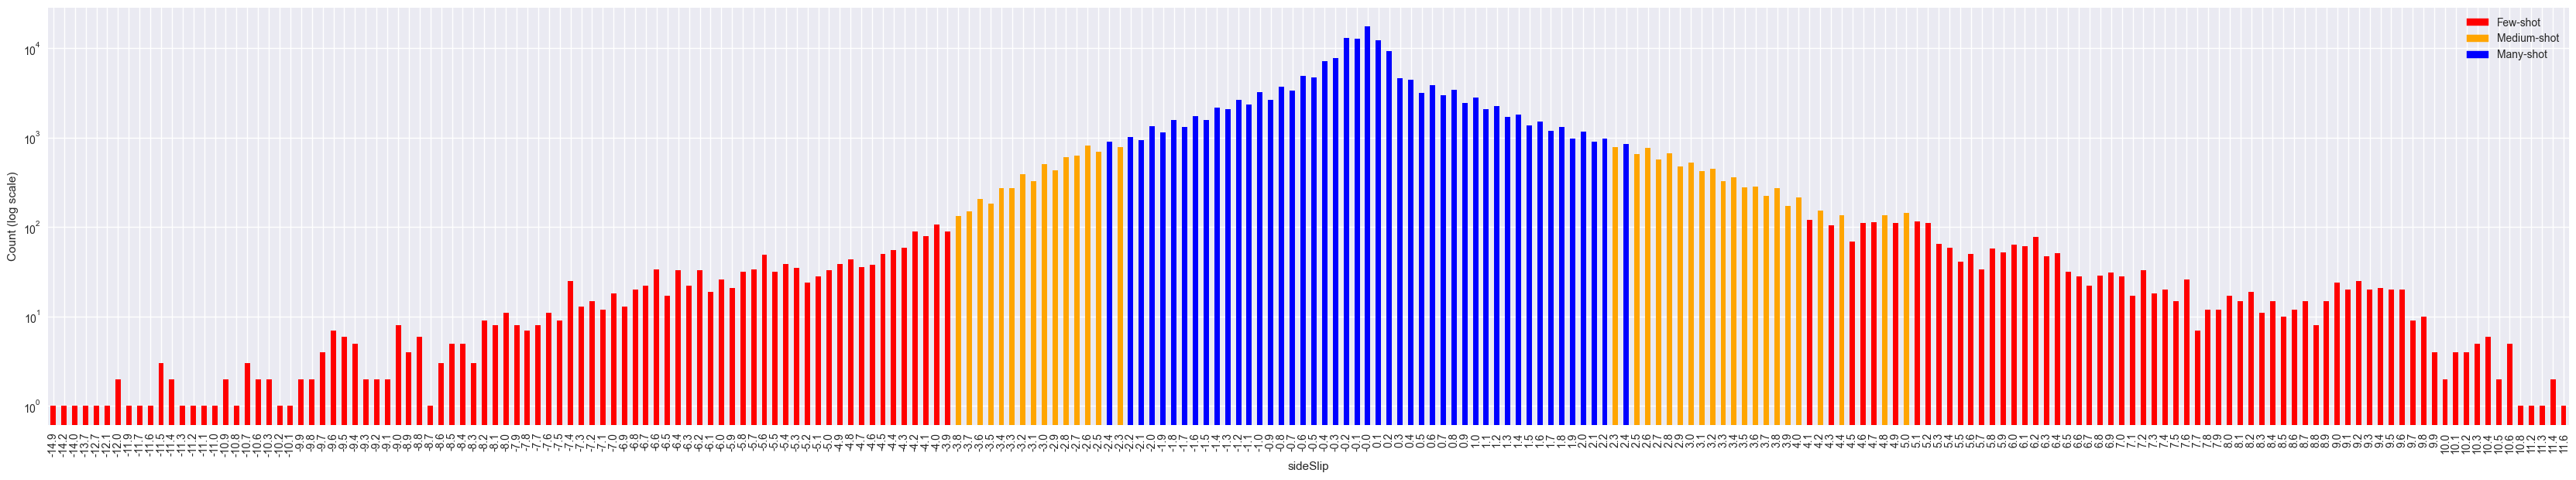

In [40]:
import matplotlib.patches as mpatches
shot_band_mapping = dist_df.groupby("sideSlip")["band"].first()
colors = shot_band_mapping.map({"few": "red", "medium": "orange", "many": "blue"})
ax = dist_df.plot(x='sideSlip', y='count', kind='bar', figsize=(42, 7), fontsize=10, color=colors)
few_patch = mpatches.Patch(color='red', label='Few-shot')
medium_patch = mpatches.Patch(color='orange', label='Medium-shot')
many_patch = mpatches.Patch(color='blue', label='Many-shot')
ax.legend(handles=[few_patch, medium_patch, many_patch], loc='upper right')
plt.yscale('log')
plt.ylabel('Count (log scale)')
plt.show()

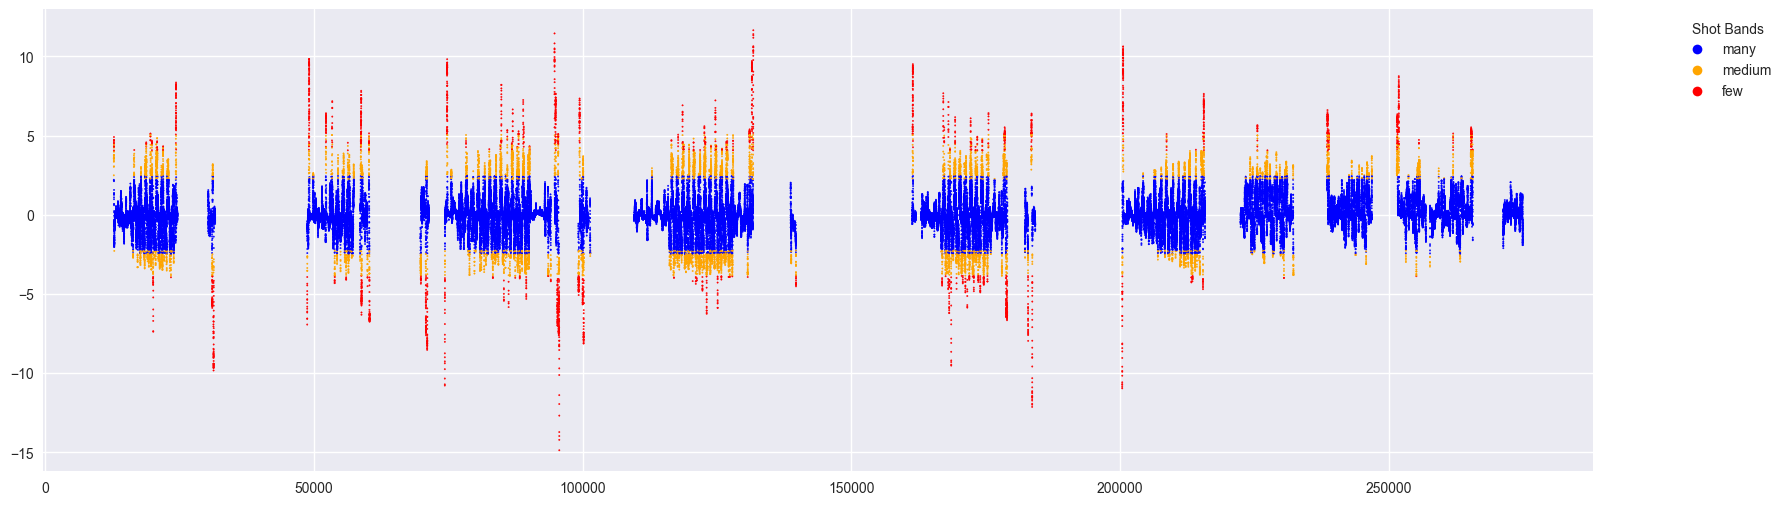

In [ ]:
def concate_csv_dir(base_dir):
    all_dfs = []
    csv_lengths = {}
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                relative_path = os.path.relpath(file_path, base_dir)
                csv_lengths[relative_path] = len(df)
                all_dfs.append(df)
    
    return all_dfs, csv_lengths


df_list, csv_lengths = concate_csv_dir("datasets_challenge/train")
train_df = pd.concat(df_list, ignore_index=True)
train_df = train_df.where(train_df["vxCG"] > 3.0).dropna()  # Apply the same thresholding as during training


train_df["band"] = train_df["sideSlip"].round(1).map(shot_band_mapping)

plt.figure(figsize=(20, 6))
plt.scatter(train_df.index, train_df["sideSlip"], c=train_df["band"].map({"many": "blue", "medium": "orange", "few": "red"}), s=1)
# Plot the color code in a legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label='many'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=7, label='medium'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='few')],
           title="Shot Bands", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 🎯 Testing Your Model with the Challenge Metric

Now comes the moment of truth! Let's evaluate your baseline model using the same metric that will be used in the official competition.

**Understanding the Metric:**
- **Dual Evaluation**: You'll get separate MAE scores for many-shot and few-shot regions
- **Success Criteria**: 
  - Few-shot MAE should be as low as possible (this is your primary score)
  - Many-shot MAE must stay ≤ 0.2° (constraint to prevent degradation)
- **Real Competition**: The Kaggle version is slightly different but gives equivalent results

**What to Expect**: Your baseline model will likely show good many-shot performance but struggle with few-shot cases - this is the challenge you need to solve!

In [41]:
from utils.kaggle_metric import score

gt_df = pd.DataFrame({"ground_truth_sideslip": ground_truths}, dtype=np.float64)
gt_df["id"] = range(len(ground_truths))
gt_df["band"] = gt_df["ground_truth_sideslip"].round(1).map(shot_band_mapping).fillna("unknown")


preds_df = pd.DataFrame({"id": range(len(preds)), "predicted_sideslip": preds})

score(gt_df, preds_df, row_id_column_name="id")

band
few       0.236782
many      0.127635
medium    0.163818
Name: L1, dtype: float64

**Performance Analysis:**
- **Many-Shot MAE: ~0.18°** ✅ (Good! Below the 0.2° threshold)
- **Few-Shot MAE: ~1.00°** 🔍 (This is your improvement target)

**What This Tells Us:**
1. **Your model works well for normal driving** - it can predict sideslip accurately when angles are small
2. **Extreme situations are challenging** - the model struggles with rare, critical scenarios
3. **Room for Improvement**: A 5x difference in performance between regions shows the classic imbalanced regression problem

**Data Distribution Context:**
Looking at the data counts below, you can see why this happens - you have ~90% many-shot data vs ~1% few-shot data for training.

**Your Mission in this Challenge**: Can you develop techniques to improve few-shot performance while maintaining many-shot accuracy?

In [42]:
gt_df["band"].value_counts()

band
many      124956
medium      9521
few         2603
Name: count, dtype: int64

And thats all. I hope you now got a feeling for:
- **Data Loading & Preprocessing**: Proper train/validation/test splitting with consistent preprocessing
- **Neural Network Training**: RNN architecture with best practices (early stopping, checkpointing)
- **Model Evaluation**: Understanding training curves and validation metrics  
- **Competition Submission**: Generating predictions in the correct format
- **Imbalanced Regression**: Recognizing and evaluating performance across different data regions

## **Good Luck with the Challange** 🏁